In [1]:
import random
import numpy as np
import skimage
from scipy.linalg import svd
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = '/Users/kayicomert/Documents/PML/assignment1/cs231n/datasets/cifar-10-batches-py/'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('one specimen shape of test', X_train[1].shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
one specimen shape of test (32, 32, 3)


(32, 32, 3)


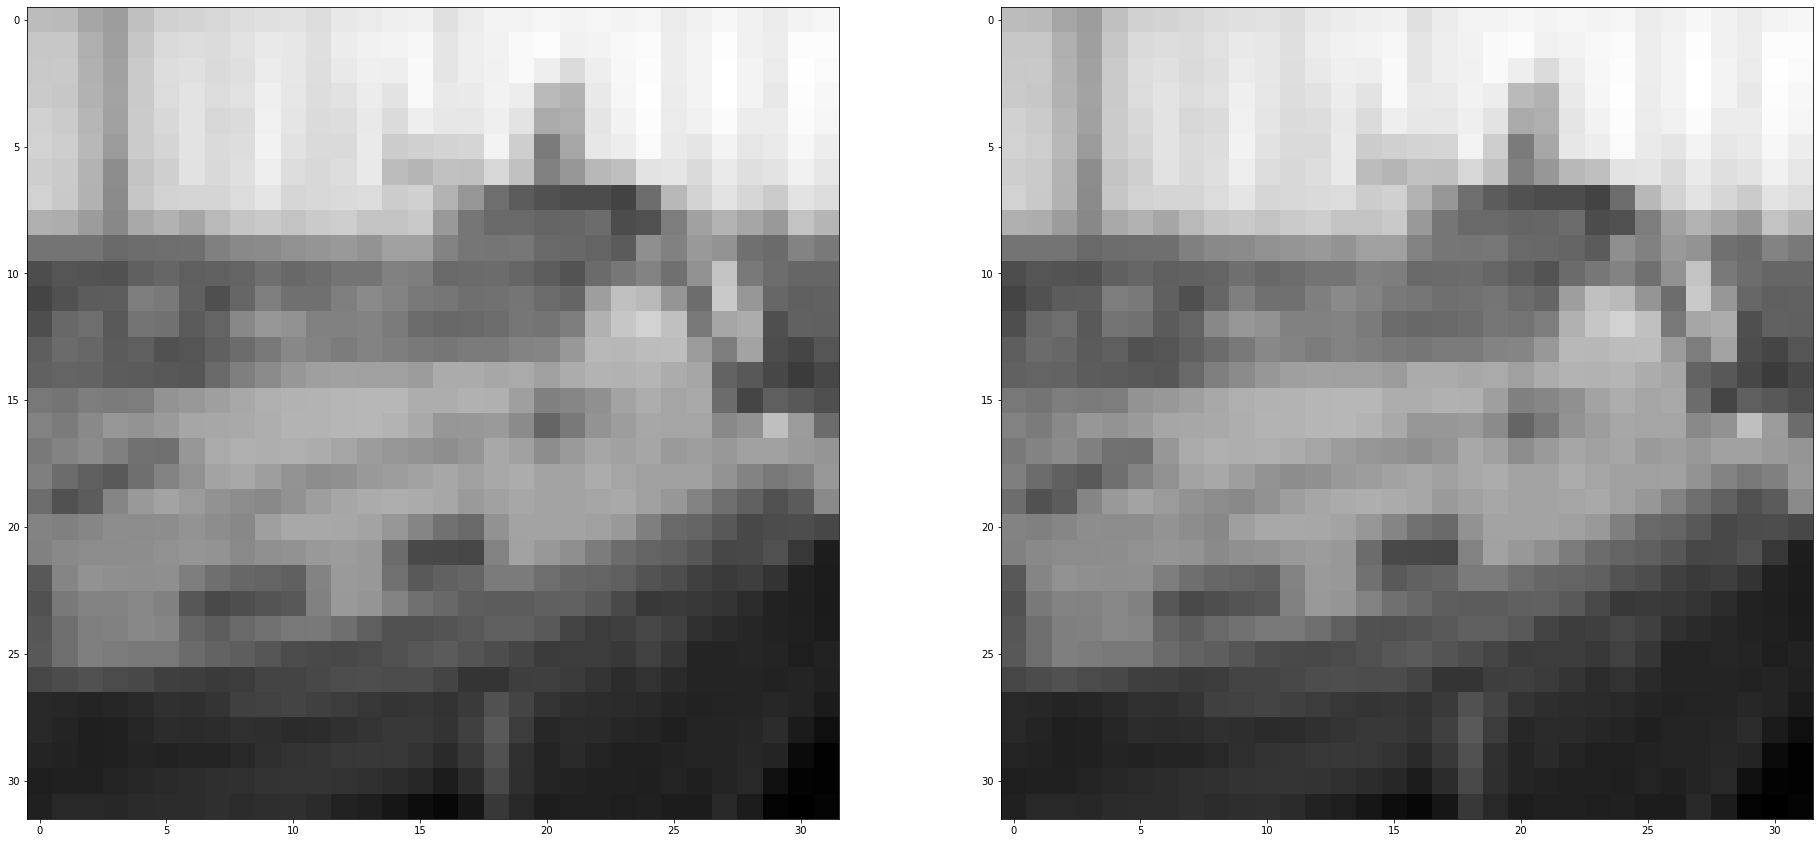

In [3]:
X_test_gray = skimage.color.rgb2gray(X_test)

num_test = 500
mask = list(range(num_test))
X_test_gray = X_test_gray[mask]
y_test = y_test[mask]
print(X_test[1].shape)
X_test_gray_comp = X_test_gray
n_component = 20 #compression multiplier
for i in range(num_test):
    U_test, s_test, V_test = svd(X_test_gray[i])
    S_test = np.zeros((X_test_gray[i].shape[0],X_test_gray[i].shape[1]))
    S_test = np.diag(s_test)
    
    S_test = S_test[:, :n_component]
    V_test = V_test[:n_component, :]
    X_test_gray_comp[i] = U_test.dot(S_test.dot(V_test))

#to show that there isn't big difference
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(32,32))
ax1.imshow(X_test_gray_comp[2])
ax2.imshow(X_test_gray[2])



(32, 32, 3)


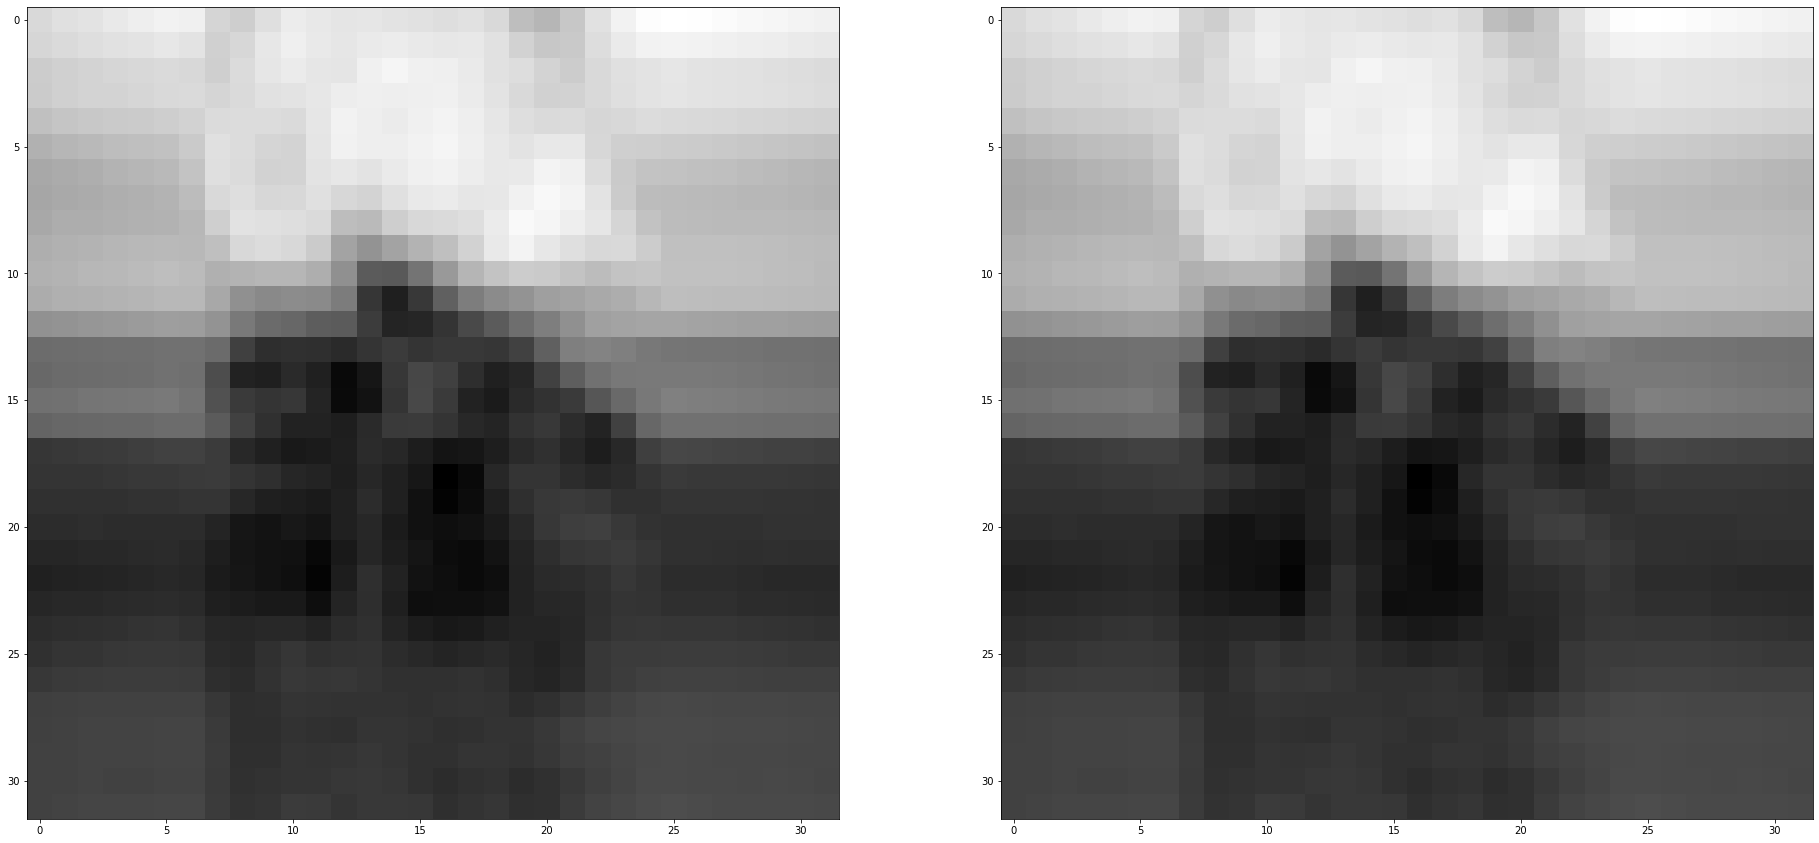

In [4]:
X_train_gray = skimage.color.rgb2gray(X_train)
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
#range is integer numbers between 0 and 5000 not including 5000
#The list() constructor returns a mutable sequence list of elements.
X_train_gray = X_train_gray[mask]
y_train = y_train[mask]
print(X_train[1].shape)
X_train_gray_comp = X_train_gray
for i in range(num_training):
    U_train, s_train, V_train = svd(X_train_gray[i])
    S_train = np.zeros((X_train_gray[i].shape[0],X_train_gray[i].shape[1]))
    S_train = np.diag(s_train)
    
    S_train = S_train[:, :n_component]
    V_train = V_train[:n_component, :]
    X_train_gray_comp[i] = U_train.dot(S_test.dot(V_test))
#to show that there isn't big difference
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(32,32))
ax1.imshow(X_train_gray_comp[2])
ax2.imshow(X_train_gray[2])



In [5]:
X_train = X_train_gray_comp
X_test = X_test_gray_comp

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 1024) (500, 1024)


### Cross-validation

We will determine the best value of this hyperparameter with cross-validation.

In [7]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
#k-fold Cross Validation test for best k_choice
range_split = np.array_split(range(X_train.shape[0]), num_folds)
y_train_folds = [ y_train[range_split[i]] for i in range(num_folds)]
X_train_folds = [ X_train[range_split[i]] for i in range(num_folds)]

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


for k in k_choices:
    for fold in range(num_folds):
        temp_X_test = X_train_folds[fold]
        temp_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])
        from cs231n.classifiers import KNearestNeighbor
        # Remember that training a kNN classifier is a noop: 
        # the Classifier simply remembers the data and does no further processing
        #noop is the function doesn't return anything
        classifier = KNearestNeighbor()
        #classifier is the object of KNearestNeighbor function
        classifier.train(temp_X_train, temp_y_train)
        dists = classifier.compute_distances_one_loop(temp_X_test)
        y_test_pred = classifier.predict_labels(dists, k=k)
        
        num_correct = np.sum(y_test_pred == temp_y_test)
        num_test = temp_X_test.shape[0]
        accuracy = (float(num_correct) / num_test)*100
        k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]
    pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))